# Macro (Zillow) Time Series Analysis and Prediction

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.stats as ss
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error 
from sklearn.utils import check_array
from sklearn.utils.validation import check_array
import pmdarima as pm

In [2]:
cleaneddata = 'data/Cleaned/Zip_ListingSale_Clean.csv' #https://www.zillow.com/research/data/
dfZillow = pd.read_csv(cleaneddata)

In [3]:
# Zip codes from Miguel for Miami-Dade and Broward County
MiamiDadeCounty_ZipCodes =  [
                            '33146','33145','33147','33150','33149','33154','33153','33156','33155','33158',
                            '33157','33160','33162','33161','33166','33165','33168','33167','33170','33169',
                            '33173','33172','33175','33174','33177','33176','33179','33178','33181','33180',
                            '33183','33182','33185','33184','33187','33186','33189','33188','33190','33194',
                            '33193','33196','33199','33242','33239','33106','33191','33206','33010','33013',
                            '33012','33015','33014','33016','33018','33027','33031','33030','33033','33032',
                            '33035','33034','33039','33055','33054','33056','33195','33090','33092','33101',
                            '33109','33112','33116','33114','33119','33122','33126','33125','33128','33127',
                            '33130','33129','33132','33131','33134','33133','33136','33135','33138','33137',
                            '33140','33139','33142','33141','33144','33143'
                            ]
BrowardCounty_ZipCodes =    [
                            '33302','33301','33304','33306','33305','33308','33310','33309','33312','33311',
                            '33314','33313','33316','33315','33318','33317','33319','33322','33321','33324',
                            '33323','33326','33325','33328','33327','33330','33329','33332','33331','33335',
                            '33334','33336','33338','33351','33394','33388','33004','33009','33008','33441',
                            '33442','33019','33021','33020','33023','33022','33025','33024','33026','33029',
                            '33028','33060','33062','33064','33063','33066','33065','33068','33067','33069',
                            '33071','33073','33076'
                            ]

In [19]:
# Convert Date object to datetime
dfZillow["Date"] = pd.to_datetime(dfZillow["Date"], format="%Y-%m")
dfZillow.dtypes

Date       datetime64[ns]
ZipCode             int64
City               object
State              object
Metro              object
County             object
Listing           float64
Sale                int64
dtype: object

In [20]:
# Miami-Dade
dfMiami = dfZillow[dfZillow['County'].str.contains('Miami')]
dfMiami = dfMiami.groupby(['Date'])['Listing', 'Sale'].median().reset_index()
dfMiami[:5]

Date   Listing    Sale
0 2010-01-01  216250.0  162000
1 2010-02-01  214900.0  159400
2 2010-03-01  209950.0  169100
3 2010-04-01  199900.0  167400
4 2010-05-01  199000.0  170200

Text(0, 0.5, 'Price')

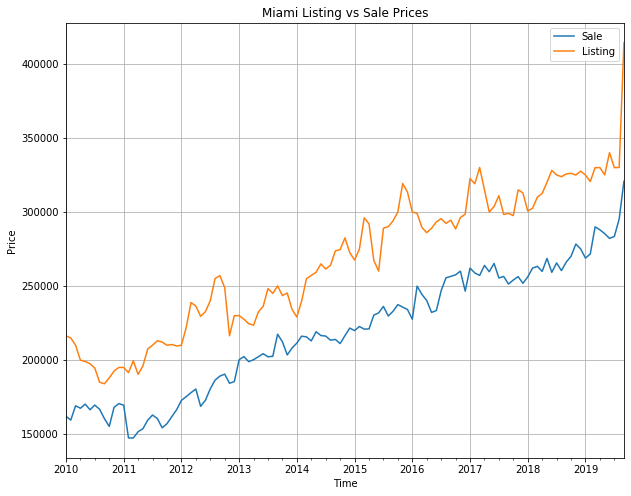

In [21]:
# Miami-Dade - Line
dfMiami[['Date','Sale','Listing']].plot('Date', figsize=(10,8), grid=True, 
                                                 title="Miami Listing vs Sale Prices")
plt.xlabel('Time')
plt.ylabel('Price')

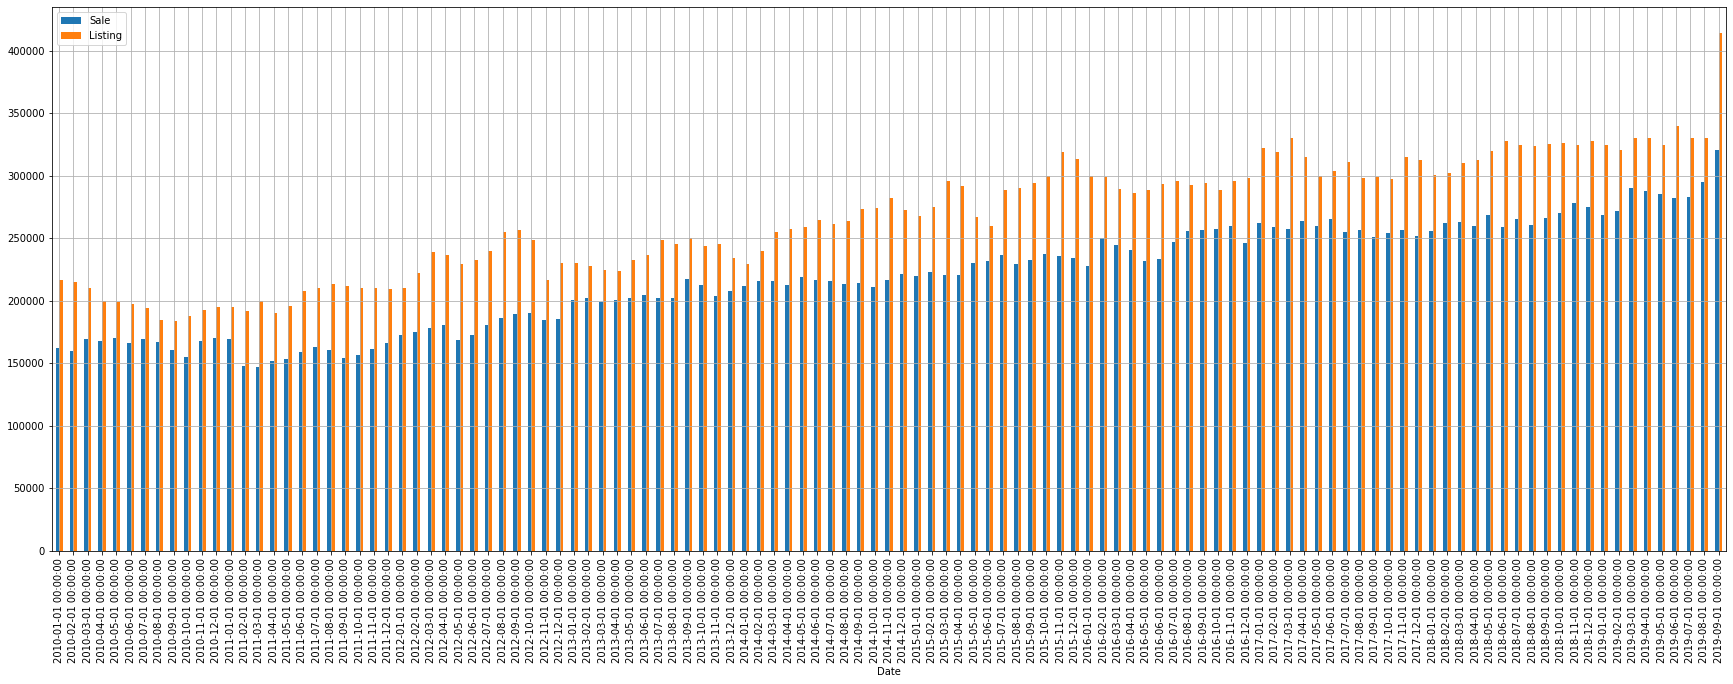

In [22]:
# Miami-Dade - Bar
dfMiami[['Date','Sale', 'Listing']].plot('Date', figsize=(30,10), kind='bar', grid=True)

# SARIMA Prediction

Using zip code because large scale predictions produce unreliable results.

In [23]:
# Change zip code and rerun this cell forward to update prediction by zip code
# using final seasonal ARIMA model
zipcode = 33134

dfZip = dfZillow.loc[(dfZillow['ZipCode'] == zipcode), ['Date', 'Listing']]
dfZip = dfZip.set_index('Date')
dfZip.head()

Listing
Date                
2012-07-01  473000.0
2012-08-01  499000.0
2012-09-01  499900.0
2012-10-01  434250.0
2012-11-01  439000.0

In [24]:
# Augmented Dicky Fuller is the most common test for stationarity
# This is observably true here with a plot, but perhaps useful
# Null hypothesis is data is non-stationary
# Source: https://machinelearningmastery.com/time-series-data-stationary-python/
result = adfuller(dfZip.Listing)
print('ADF: %f' % result[0])
print('p-value: %f' % result[1])

ADF: -0.804455
p-value: 0.817810


As expected, can't reject null hypothesis. In other words, data is non-stationary. Suggests differencing is necessary.

In [52]:
# Used train and test sets to ascertain appropriate SARIMA model order.
train = dfZip[:60]
test = dfZip[60:]

In [53]:
# SARIMA MODEL - best result after multiple tests: order=(1,0,1), seasonal_order=(1,1,0,12)
model = SARIMAX(dfZip, order=(1,0,1), seasonal_order=(1,1,0,12),   
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = model.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                            Listing   No. Observations:                   87
Model:             SARIMAX(1, 0, 1)x(1, 1, 0, 12)   Log Likelihood                -696.902
Date:                            Wed, 27 Nov 2019   AIC                           1401.804
Time:                                    14:32:21   BIC                           1410.312
Sample:                                07-01-2012   HQIC                          1405.144
                                     - 09-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9204      0.073     12.671      0.000       0.778       1.063
ma.L1         -0.0595      0.153   

/Users/rogerjimenez/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


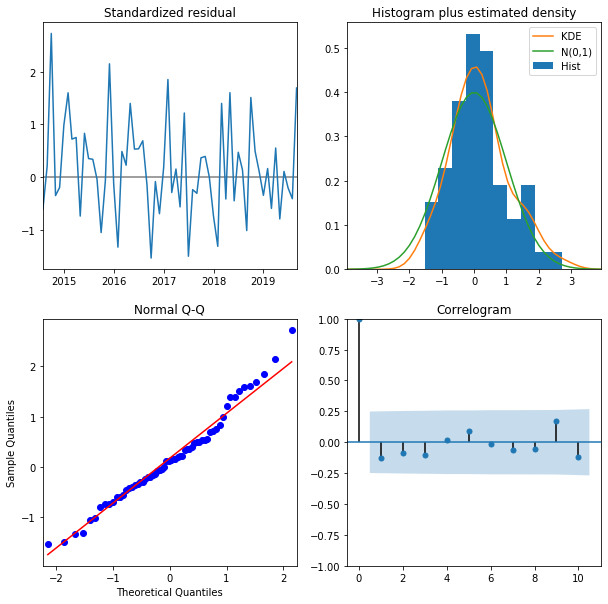

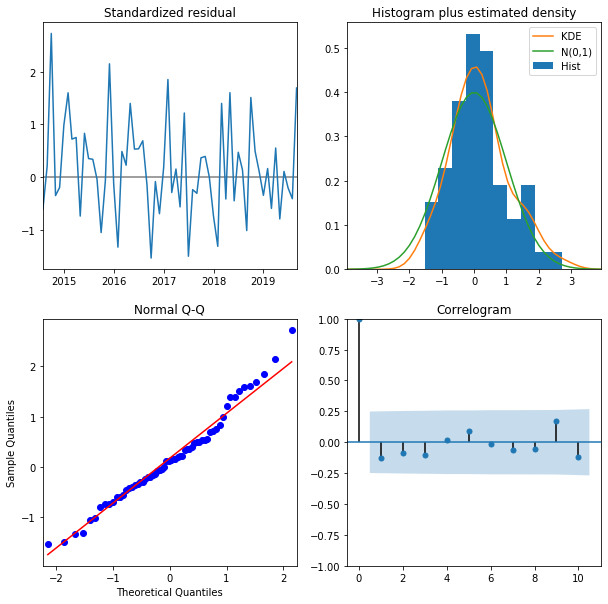

In [54]:
results.plot_diagnostics(figsize=(10,10))

Correlogram looks good after single seasonal differencing and theoretical quantities align well with sample quantities.

In [55]:
prediction = results.get_prediction(start = 0, end = 80, dynamic=False)
prediction_ci = prediction.conf_int()

In [56]:
# Get forecast of next n months
forecast = results.get_forecast(steps=25)

# Get confidence intervals of forecasts
forecast_ci = forecast.conf_int()
forecast_ci.head()

lower Listing  upper Listing
2019-10-01  559779.613088  638573.386458
2019-11-01  554192.550121  658163.949940
2019-12-01  525463.121962  646739.855806
2020-01-01  520481.265820  654682.696354
2020-02-01  520083.307583  664330.034574

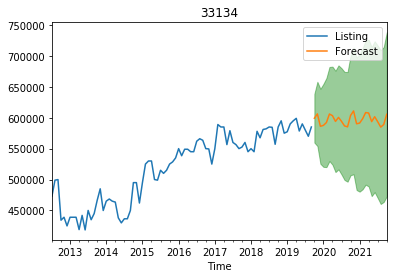

In [57]:
ax = dfZip.plot(label='Actual')
forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='g', alpha=.4)
ax.set_xlabel('Time')
ax.set_ylabel('')

plt.title(zipcode)
plt.legend()
plt.show()

In [61]:
prediction = results.get_prediction(start = 61, end = 87, dynamic=False)
prediction_ci = prediction.conf_int()

Something is wrong with MSE, etc... Need to fix

In [62]:
true = test.Listing.reset_index()
true = true.Listing
forecast = prediction.predicted_mean.reset_index()
forecast = round(forecast.iloc[:,1],1)

# Compute the mean square error and root MSE
mse = ((forecast - true) ** 2).mean()
print('Mean Squared Error (MSE): {}'.format(round(mse, 2)))
print('Root Mean Square Error (RMSE): {:.4f}'
      .format(np.sqrt(sum((forecast-true)**2)/len(forecast))))

# Compute MAPE; source: https://stackoverflow.com/questions/47648133/mape-calculation-in-python
# Comment out if divide by zero error (weakness of MAPE and MPE)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(true, forecast)

print('Mean Absolute Percentage Error (MAPE): {}'.format(round(mape, 2)))

def mean_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((y_true - y_pred) / y_true) * 100

mpe = mean_percentage_error(true, forecast)

print('Mean Absolute Percentage Error (MAPE): {}'.format(round(mape, 2)))

# Compute mean absolute error (MAE)
mae = mean_absolute_error(true, forecast)
print('Mean Absolute Error (MAE): {}'.format(round(mae, 2)))

# Mean Error
me = np.mean(true - forecast)
print('Mean Error (ME): {}'.format(round(me, 2)))

# Min-Max Accuracy (Source: https://adataanalyst.com/machine-learning/guide-for-linear-regression-using-python-part-2/)
# minmax = min(true, hourly_forecast)/max(true, hourly_forecast)
minmax = np.mean(min(min(true),min(forecast)) / max(max(true),max(forecast)))
print('Min-Max Accuracy (min-max): {}'.format(round(minmax, 3)))

# Correlation Prediction vs Actual
corr = true.corr(forecast)
print('Correlation between prediction and actual: {}'.format(round(me, 2)))


Mean Squared Error (MSE): 126022622.15
Root Mean Square Error (RMSE): 11225.9798
Mean Absolute Percentage Error (MAPE): 1.54
Mean Absolute Percentage Error (MAPE): 1.54
Mean Absolute Error (MAE): 8807.02
Mean Error (ME): 159.14
Min-Max Accuracy (min-max): 0.898
Correlation between prediction and actual: 159.14


# Miami-Dade Listing vs Sale Time Series

In [68]:
dfMiami = dfZillow[dfZillow['County'].str.contains('Miami')]
dfMiami = dfMiami.groupby(['Date'])['Listing', 'Sale'].median().reset_index()
dfMiami[:5]

Date   Listing    Sale
0 2010-01-01  216250.0  162000
1 2010-02-01  214900.0  159400
2 2010-03-01  209950.0  169100
3 2010-04-01  199900.0  167400
4 2010-05-01  199000.0  170200

Text(0, 0.5, 'Price')

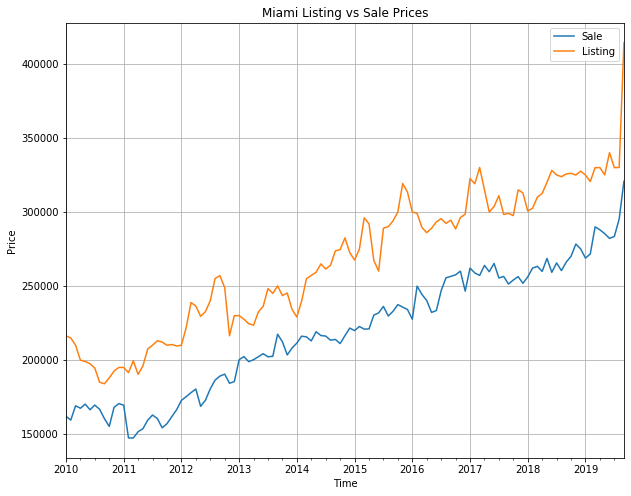

In [69]:
dfMiami[['Date','Sale','Listing']].plot('Date', figsize=(10,8), grid=True, 
                                                 title="Miami Listing vs Sale Prices")
plt.xlabel('Time')
plt.ylabel('Price')

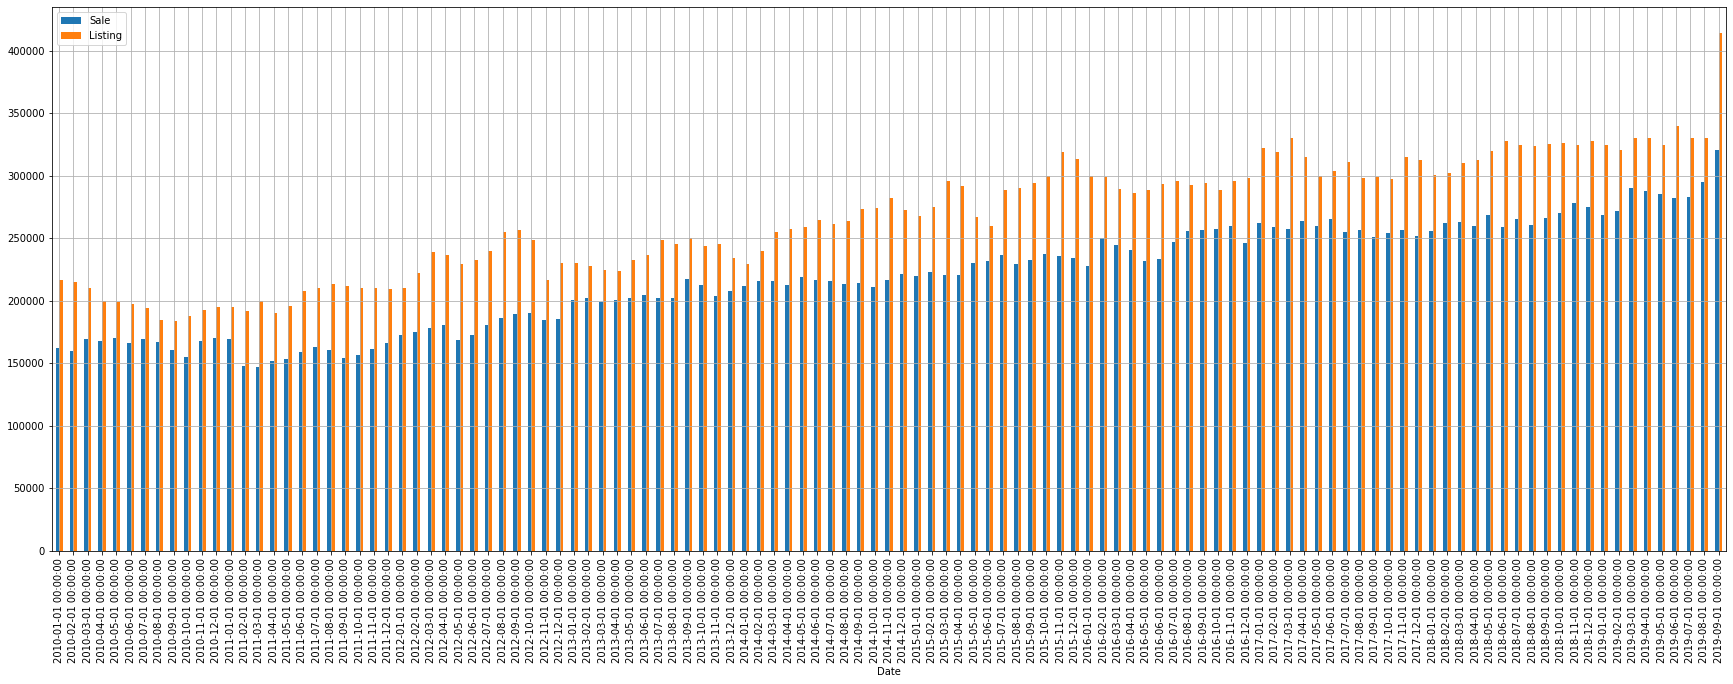

In [70]:
dfMiami[['Date','Sale', 'Listing']].plot('Date', figsize=(30,10), kind='bar', grid=True)

In [74]:
# Difference between sales and listing; percRedux = (listing - sale)/listing
dfMiami['PercRedux'] = (dfMiami['Listing']-dfMiami['Sale'])\
    /dfMiami['Listing']
dfMiami.PercRedux = (dfMiami.PercRedux * 100).round()
dfMiami[:5]

Date   Listing    Sale  PercRedux
0 2010-01-01  216250.0  162000       25.0
1 2010-02-01  214900.0  159400       26.0
2 2010-03-01  209950.0  169100       19.0
3 2010-04-01  199900.0  167400       16.0
4 2010-05-01  199000.0  170200       14.0

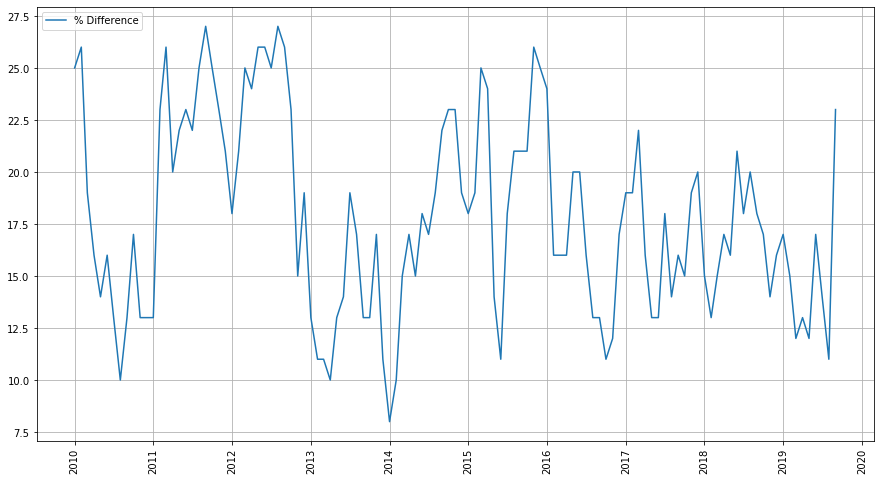

In [75]:
plt.figure(figsize = (15, 8))
plt.xticks(rotation=90)
plt.grid()
plt.plot(dfMiami.Date, dfMiami.PercRedux)
plt.legend(['% Difference'], loc='upper left')

Notice seasonal pattern.

# Broward Listing vs Sale Time Series

In [71]:
dfBroward = dfZillow[dfZillow['County'].str.contains('Broward')]
dfBroward = dfBroward.groupby(['Date'])['Listing', 'Sale'].median().reset_index()
dfBroward['PercRedux'] = (dfBroward['Listing']-dfBroward['Sale'])\
    /dfBroward['Listing']
dfBroward.PercRedux = (dfBroward.PercRedux * 100).round()
dfBroward[:5]

Date    Listing    Sale  PercRedux
0 2010-01-01  297450.00  190000       36.0
1 2010-02-01  293728.25  204400       30.0
2 2010-03-01  279999.75  203150       27.0
3 2010-04-01  290088.50  206750       29.0
4 2010-05-01  283749.75  184650       35.0

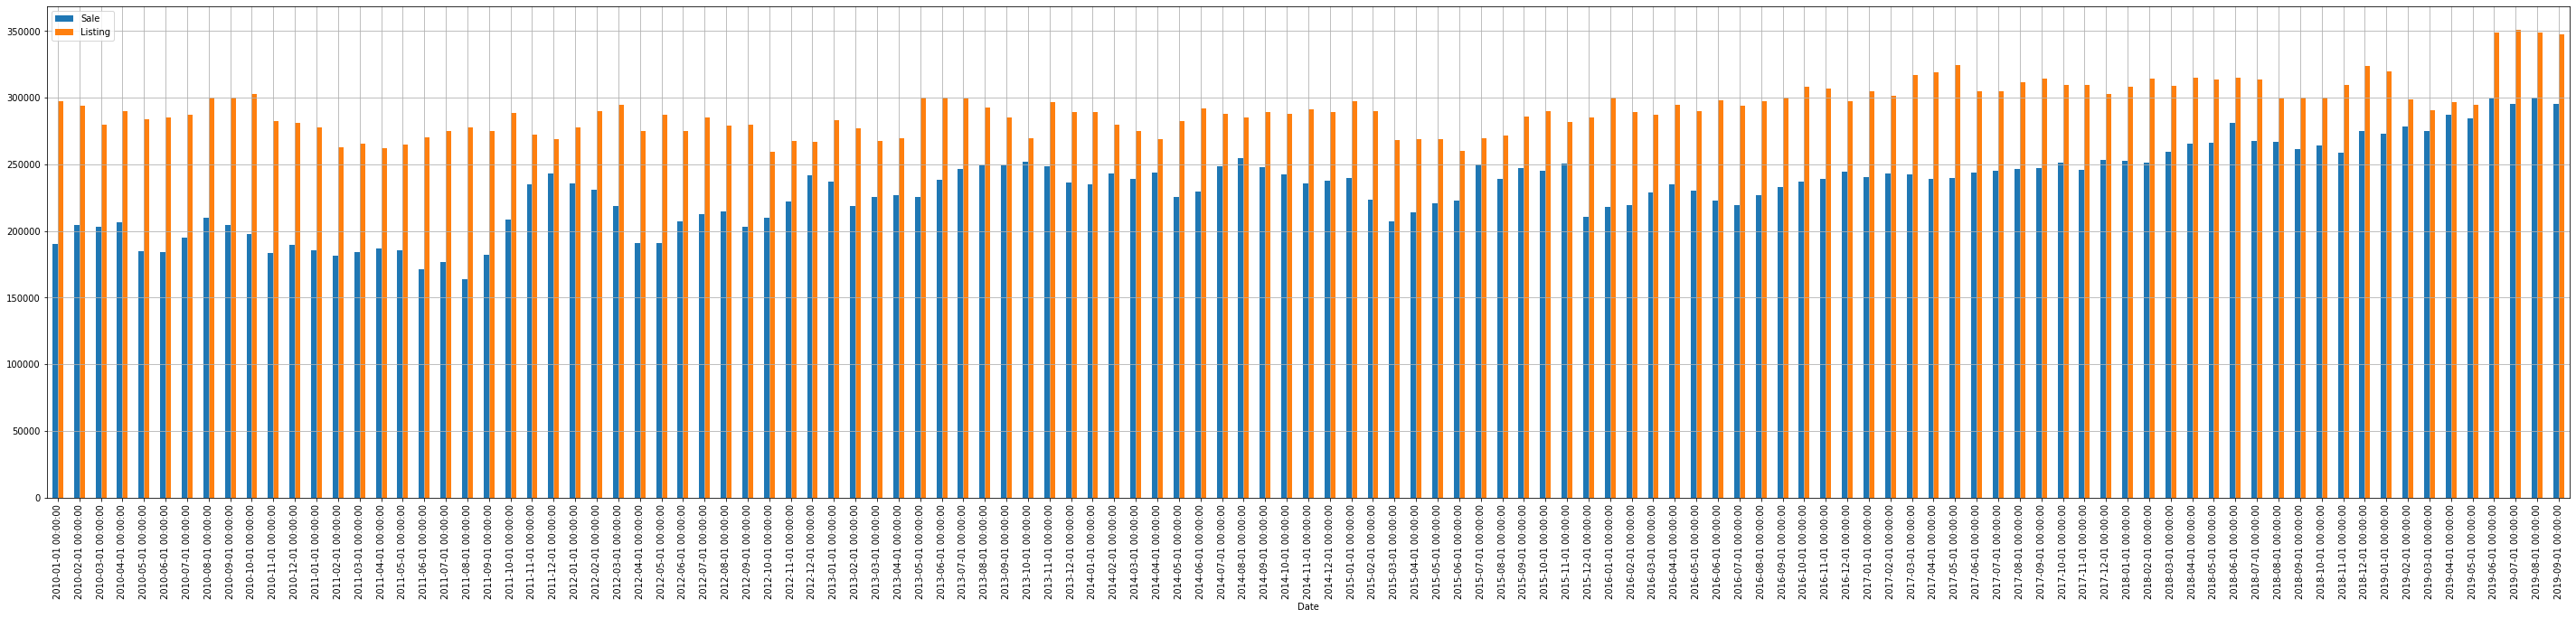

In [73]:
dfBroward[['Date','Sale', 'Listing']].plot('Date', figsize=(50,10), kind='bar', grid=True)

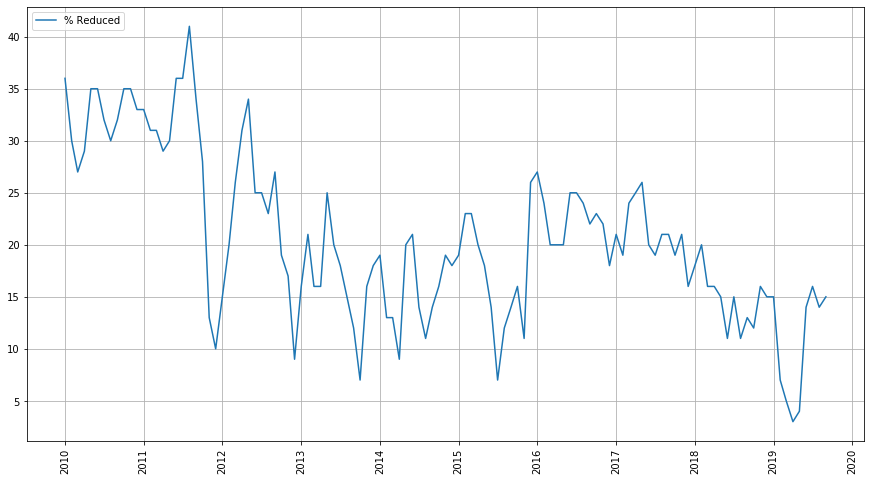

In [76]:
plt.figure(figsize = (15, 8))
plt.xticks(rotation=90)
plt.grid()
plt.plot(dfBroward.Date, dfBroward.PercRedux)
plt.legend(['% Reduced'], loc='upper left')

# Miami-Dade vs Broward Time Series

In [77]:
# Correlation between percentage difference for Dade and Broward
dfMiami.PercRedux.corr(dfBroward.PercRedux)

0.2697101286290812

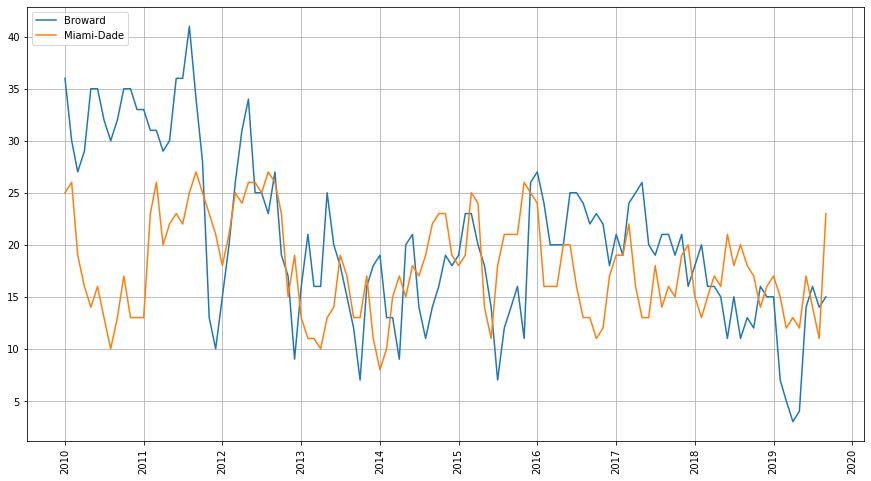

In [79]:
plt.figure(figsize = (15, 8))
plt.xticks(rotation=90)
plt.grid()
plt.plot(dfBroward.Date, dfBroward.PercRedux)
plt.plot(dfMiami.Date, dfMiami.PercRedux)
plt.legend(['Broward', 'Miami-Dade'], loc='upper left')

In [82]:
# Adding zip codes for later analysis
dfMiami_zip = dfZillow[dfZillow['County'].str.contains('Miami')]
dfMiami_zip = dfMiami_zip.groupby(['Date', 'ZipCode'])['Listing', 'Sale'].median().reset_index()

dfBroward_zip = dfZillow[dfZillow['County'].str.contains('Broward')]
dfBroward_zip = dfBroward_zip.groupby(['Date', 'ZipCode'])['Listing', 'Sale'].median().reset_index()